# Model Input Layer - Manning's Roughness

### Goal

Create a `.dfsu` roughness map as a MIKE21 HD model input layer corresponding to elements from an unstructured `.mesh`, taking roughness values from a GIS polygon vector `.shp` file that outlines regions of roughness values.

In [4]:
from dhitools import mesh

----
## tl;dr

Minimum steps to create roughness `.dfsu` from input `.mesh` and roughness `.shp`

In [2]:
mesh_f = 'data/example_mesh_no_elevation.mesh' # Mesh files
roughness_shp = 'data/shp/roughness.shp' # Roughness map
dfsu_out = 'data/roughness.dfsu' # Output dfsu

field_attribute = 'Manning_n'

m = mesh.Mesh(mesh_f) # Load mesh
m.lyr_from_shape('roughness', roughness_shp, field_attribute) # Get roughness values for mesh elements from roughness map
m.lyr_to_dfsu('roughness', dfsu_out) # Write dfsu

----

## Outline

- Load `.mesh` and roughness map `.shp` file
- Inspect these files
- Assign roughness values from `.shp` file to mesh elements
- Write a new `.dfsu` file


In [75]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

## Load Files

In [5]:
mesh_f = 'data/example_mesh_no_elevation.mesh' # Mesh files
roughness_shp = 'data/shp/roughness.shp' # Roughness map

Load the mesh and roughness map

In [7]:
m = mesh.Mesh(mesh_f)
roughness_map = gpd.read_file(roughness_shp)

Mesh summary:

In [8]:
m.summary()

Input mesh file: data/example_mesh_no_elevation.mesh
Num. Elmts = 800
Num. Nodes = 512
Mean elevation = 0.0
Projection = 
 PROJCS["GDA_1994_MGA_Zone_56",GEOGCS["GCS_GDA_1994",DATUM["D_GDA_1994",SPHEROID["GRS_1980",6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000],PARAMETER["False_Northing",10000000],PARAMETER["Central_Meridian",153],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0],UNIT["Meter",1]]


The `Geopandas` library is used to load the roughness file, which allows for `pandas` style dataframe functionality

In [22]:
roughness_map.shape

(304, 14)

In [10]:
roughness_map.head()

,OBJECTID,QLUMP_CODE,PRIMARY,SECONDARY,TERTIARY,Manning_n,inv_mann_n,Class_Name,Id,ROAD,Shape_Leng,Shape_Le_1,Shape_Area,geometry
0,0,0,None,None,None,0.025,40.0,Coastal Water,0,0.0,0.0,893089.340340,2.948710e+09,"POLYGON ((538366.4013483515 7232355.935799949,..."
1,0,0,None,None,None,0.025,40.0,Coastal Water,0,0.0,0.0,1507.683439,3.696424e+04,"POLYGON ((447845.9320874052 7249123.273189012,..."
2,0,0,None,None,None,0.025,40.0,Coastal Water,0,0.0,0.0,32577.239684,4.024320e+06,"POLYGON ((448050.3153323128 7241192.393661046,..."
3,0,0,None,None,None,0.025,40.0,Coastal Water,0,0.0,0.0,17094.300845,3.056761e+06,"POLYGON ((523660.2675399155 7238256.11602405, ..."
4,0,0,None,None,None,0.025,40.0,Coastal Water,0,0.0,0.0,9822.985870,6.001529e+05,"POLYGON ((448569.4988675959 7238605.131837157,..."


These are all of the attributes within the roughness map with each row of the dataframe corresponding to a polygon. We're interested in obtaining the `Manning_n` value for each mesh element

*For demo purposes, the roughness map covers a subset of the mesh to keep file size reasonable.*

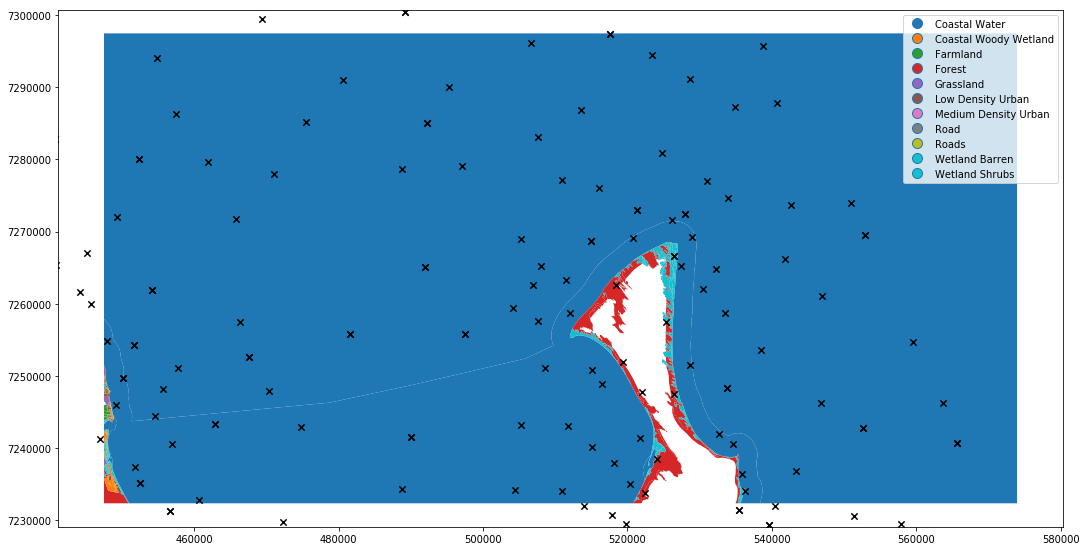

In [63]:
fig, ax = plt.subplots(figsize=(18,10))
roughness_map.plot(column = 'Class_Name', ax=ax, legend=True, categorical=True)#, cmap=cm.cool)
shp_x = ax.get_xlim()
shp_y = ax.get_ylim()
ax.scatter(m.elements[:,0], m.elements[:,1], color='k', s=40, marker='x')
ax.set_ylim(shp_y)
ax.set_xlim(shp_x)
ax.set_aspect('equal')
plt.show()

The figure shows the different polygon classes and the crosses show the centre of mesh elements. A spatial join will be performed on the mesh element points and the Manning's n value for whichever polygon an element is within.

## Roughness Values for Mesh Elements

From the `dhitools` `mesh` object we can call the method `lyr_from_shape` which accepts a layer name to save to, path to the `.shp` file we're interested in (ie. the roughness map) and the field in the shape files attribute table to extract values from after the spatial join.

In [65]:
lyr_name = 'roughness' # This is just a dictionary key to access the extracted results

Roughness `.shp` file is as before

In [67]:
roughness_shp

'data/shp/roughness.shp'

Field attribute is the 'Manning_n', as seen in the `roughness_map` GeoDataFrame above

In [66]:
field_attribute = 'Manning_n'

Call the `lyr_from_shape` function

In [69]:
m.lyr_from_shape(lyr_name, roughness_shp, field_attribute)

This saves the values in the mesh `lyrs` attribute in a dictionary, accessed by the `lyr_name` (the dictionary key) 

In [74]:
m.lyrs['roughness'][:150]

array([  nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan, 0.025,   nan,   nan, 0.025, 0.025,
         nan, 0.025,   nan,   nan, 0.025,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan, 0.025,   nan,   nan, 0.025,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan, 0.025,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan, 0.025,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan, 0.07 , 0.07 ,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan, 0.025,   nan,   nan,   nan,   nan,
         nan,   nan,

A lot of these values are `nan` because the roughness map only covers a subset of the mesh.

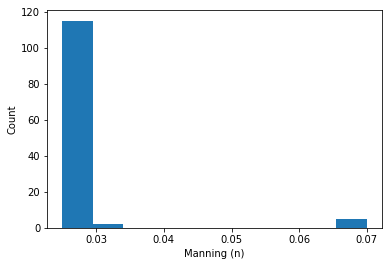

In [88]:
plt.hist(m.lyrs['roughness'][~np.isnan(m.lyrs['roughness'])], bins=10)
ax = plt.gca()
ax.set_xlabel('Manning (n)')
ax.set_ylabel('Count')
plt.show()

## Output .dfsu

Call `lyr_to_dfsu` to write the roughness values for each mesh element to a `.dfsu`.

Accepts input, `lyr_name` to get the values, and a path to the output `.dfsu`

In [90]:
dfsu_out = 'data/roughness.dfsu'

In [91]:
m.lyr_to_dfsu(lyr_name, dfsu_out)